In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as ply

In [2]:
pip install pymysql

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pymysql

connection = pymysql.connect(
    host='localhost',        
    user='root',
    password='qwerty@1234',
    database='credit_risk_project'
)


query = "SELECT * FROM customer_features;"

df = pd.read_sql(query, connection)
          
connection.close()


print(df.head())


   customer_id  age    income employment_type region  num_loans  \
0         1001   59  155090.0        Salaried  North          0   
1         1002   49   31302.0   Self-Employed  North          0   
2         1003   35   87506.0        Salaried   West         20   
3         1004   63   61157.0        Salaried   West          0   
4         1005   28   74917.0        Salaried  North          0   

   loan_amount_total  avg_interest_rate  avg_tenure_months  num_repayments  \
0                NaN                NaN                NaN               0   
1                NaN                NaN                NaN               0   
2          4095572.0              13.78               29.6              20   
3                NaN                NaN                NaN               0   
4                NaN                NaN                NaN               0   

   total_paid_amount  late_payment_ratio  
0                NaN                 NaN  
1                NaN                 NaN  

C:\Users\bajaj\AppData\Local\Temp\ipykernel_16028\833050264.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [5]:
df['risk_label'] = df['late_payment_ratio'].apply(lambda x: 1 if x > 0.4 else 0)

In [6]:
df_full = df.copy()
df = df.dropna(subset=['risk_label']) 
df = df.drop(columns=['customer_id','late_payment_ratio']) 

In [7]:
X = df.drop(columns=['risk_label'])
y = df['risk_label']

In [8]:
X = X.fillna(X.median(numeric_only=True))
X = X.fillna("Unknown")
X = pd.get_dummies(X, drop_first=True)

In [9]:
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.3, random_state=42, stratify=y_bal
)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
lr_preds = lr.predict(X_test_scaled)
print("Logistic Regression Report:\n", classification_report(y_test, lr_preds))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.94      0.68      0.79       166
           1       0.75      0.96      0.84       165

    accuracy                           0.82       331
   macro avg       0.85      0.82      0.82       331
weighted avg       0.85      0.82      0.82       331



In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_test_scaled)
print("Random Forest Report:\n", classification_report(y_test, rf_preds))

Random Forest Report:
               precision    recall  f1-score   support

           0       0.98      0.69      0.81       166
           1       0.76      0.99      0.86       165

    accuracy                           0.84       331
   macro avg       0.87      0.84      0.84       331
weighted avg       0.87      0.84      0.84       331



In [14]:
model = XGBClassifier(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\bajaj\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:27:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[118  48]
 [ 15 150]]
              precision    recall  f1-score   support

           0       0.89      0.71      0.79       166
           1       0.76      0.91      0.83       165

    accuracy                           0.81       331
   macro avg       0.82      0.81      0.81       331
weighted avg       0.82      0.81      0.81       331



In [15]:
X_all = df_full.drop(columns=['customer_id', 'risk_label'])
X_all_encoded = pd.get_dummies(X_all, drop_first=True)
X_all_encoded = X_all_encoded.reindex(columns=X.columns, fill_value=0)
X_all_scaled = scaler.transform(X_all_encoded)

from sklearn.calibration import CalibratedClassifierCV
calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv=5)
calibrated_model.fit(X_train_scaled, y_train)

risk_probs = calibrated_model.predict_proba(X_all_scaled)[:, 1]


risk_probs = calibrated_model.predict_proba(X_all_scaled)[:, 1]
risk_labels = calibrated_model.predict(X_all_scaled)

results = pd.DataFrame()
results['customer_id'] = df_full['customer_id']  
results['credit_risk_score'] = risk_probs.round(2)
results['risk_label'] = risk_labels
results['prediction_date'] = pd.Timestamp.today().date()

print(results)


C:\Users\bajaj\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:27:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\bajaj\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:27:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\bajaj\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:27:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\bajaj\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:27:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

     customer_id  credit_risk_score  risk_label prediction_date
0           1001               0.04           0      2025-07-22
1           1002               0.01           0      2025-07-22
2           1003               0.77           1      2025-07-22
3           1004               0.02           0      2025-07-22
4           1005               0.06           0      2025-07-22
..           ...                ...         ...             ...
995         1996               0.02           0      2025-07-22
996         1997               0.82           1      2025-07-22
997         1998               0.03           0      2025-07-22
998         1999               0.81           1      2025-07-22
999         2000               0.74           1      2025-07-22

[1000 rows x 4 columns]


In [16]:
import pymysql
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy import create_engine

url = URL.create(
    drivername="mysql+pymysql",
    username="root",           
    password="qwerty@1234",   
    host="localhost",
    port=3306,                          
    database="credit_risk_project"
)

engine = create_engine(url)

results.to_sql("credit_scores", con=engine, if_exists="replace", index=False)

print("✅ Predictions uploaded successfully!")

✅ Predictions uploaded successfully!


In [17]:
pd.Series(risk_probs.round(2)).value_counts().head(10)


0.02    112
0.01     78
0.03     63
0.78     62
0.77     57
0.82     44
0.81     38
0.83     34
0.76     30
0.75     28
Name: count, dtype: int64

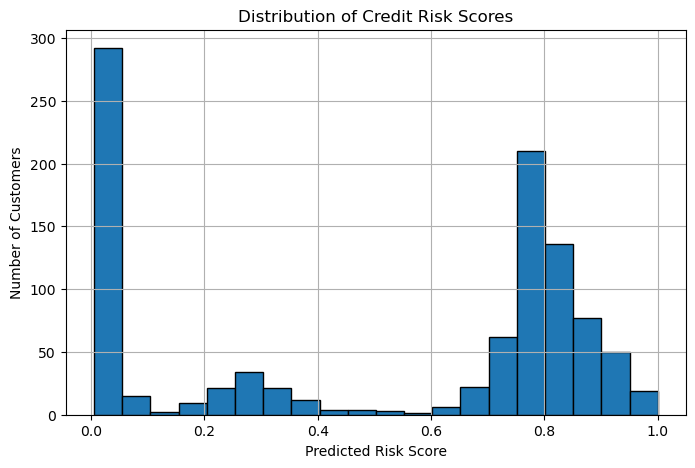

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
pd.Series(risk_probs).plot(kind='hist', bins=20, edgecolor='black')
plt.title("Distribution of Credit Risk Scores")
plt.xlabel("Predicted Risk Score")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.show()
